In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from astropy.io import fits

show_title = False # Set this to true to print the title of the plots.
# For the report, it should not display a title AND the figure caption

In [34]:
# Global style
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler(color=["black"] 
                            + plt.rcParams['axes.prop_cycle'].by_key()['color']),
    "font.family": "serif",             # Serif fonts (e.g., Times-like)
    "font.serif": ["Linux Libertine"],  # Same font as in LaTeX
    "font.size": 14,                    # Base font size
    "mathtext.fontset": "cm",           # Math Font to match a bit better
    "legend.fontsize": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,                  # High resolution
    "savefig.dpi": 300,
    "axes.linewidth": 0.8,              # Thin axis lines
    "xtick.direction": "in",            # Ticks pointing inward
    "ytick.direction": "in",
    "xtick.top": True,                  # Ticks on all sides
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "grid.linewidth": 0.4
})

small_fsize = (4,2.75) # for a single colum in double colum
wide_fsize = (6.5,4)

In [35]:
# object IDs and redshifts

IDs_34 = [772,804,1109,1167,1961,8803,16125,22266,22812,26566,26788,27145,30578,31479,31873,49372,70173,71890,79534]
IDs_56 = [113,761,903,3012,6189,14285,24707,44699,47918,53927,54834,62309,79349,80185,81497,83030]

z_34 = [3.8531,3.6645,3.9183,3.6673,3.6418,3.208,3.3659,3.1371,3.0736,3.1336,3.8499,3.2001,3.1317,3.2072,3.2334,3.2435,3.0043,3.4183,3.2167]
z_56 = [5.788,5.546,5.7762,5.277,5.1834,5.4415,5.9383,5.0355,5.7774,5.8725,5.778,5.1747,5.1794,5.4926,5.3967,5.1236]

# function to open fits files
def open_fits(ID):
    filename = f"FITS/{ID}.fits"
    with fits.open(filename) as hdul:
        data = hdul[1].data 
        wavelength = data.wave
        flux = data.flux
        error = data.err
    return wavelength, flux, error

## (ii)

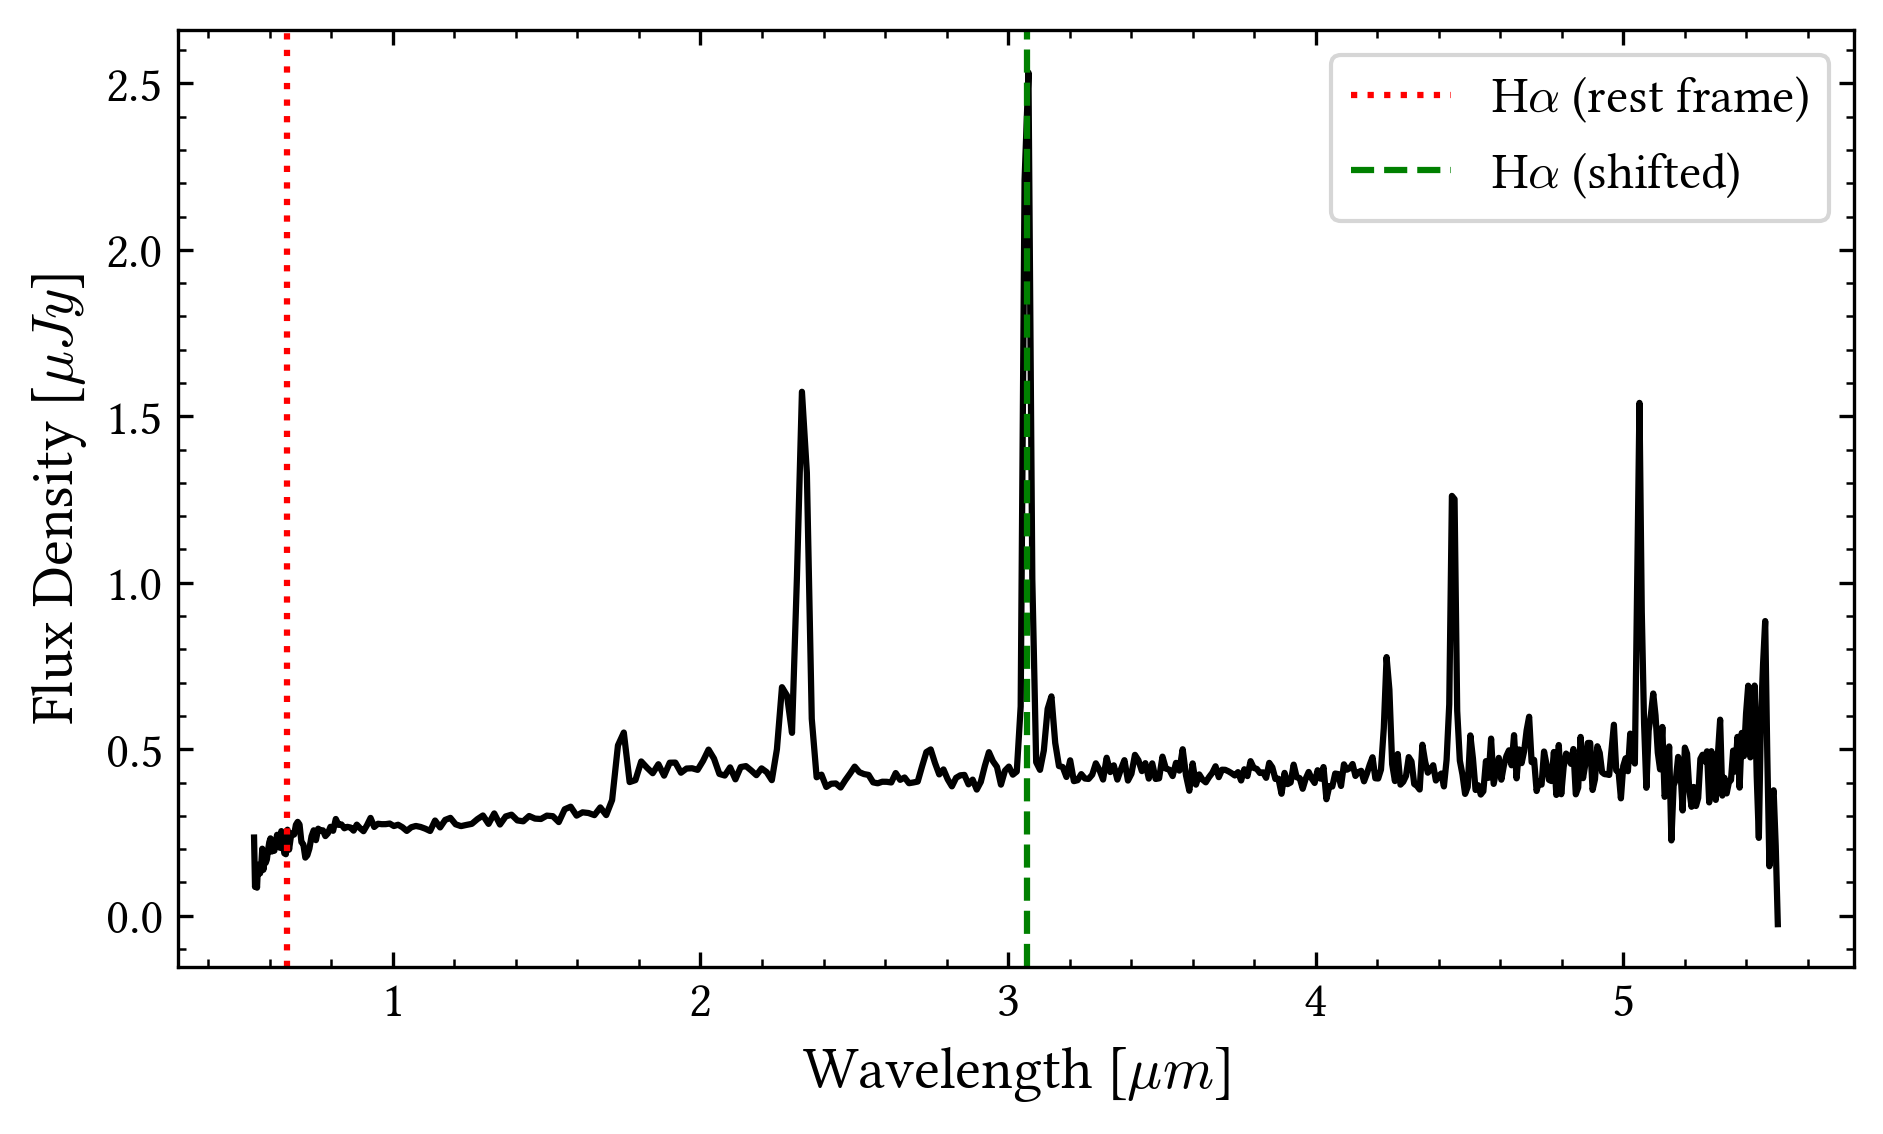

In [36]:
fig = figure(figsize=wide_fsize)
frame = fig.add_subplot()

# create dictionaries for easier look-up
id_to_z = dict(zip(IDs_34, z_34))
id_to_z.update(dict(zip(IDs_56, z_56)))

#one visualization
ID = 804
z_value = id_to_z.get(ID, None)
Ha = 6563 #angstrom

wave, flux, error = open_fits(ID)

frame.plot(wave, flux)

frame.set_ylabel(r'Flux Density [$\mu Jy$]')
frame.set_xlabel(r'Wavelength [$\mu m$]')

#rest-frame
frame.axvline(Ha*1e-4,c='red',linestyle=':',label=r'H$\alpha$ (rest frame)')

#redshifted
frame.axvline((Ha*1e-4*z_value + Ha*1e-4),c='green',linestyle='--',label=r'H$\alpha$ (shifted)') 
if show_title: frame.set_title(f'Spectrum Visualization for ID {ID} with $z={z_value}$')
frame.legend()
plt.tight_layout()
plt.savefig(fname='spectrum_visualization.pdf')
show()



## (iii)

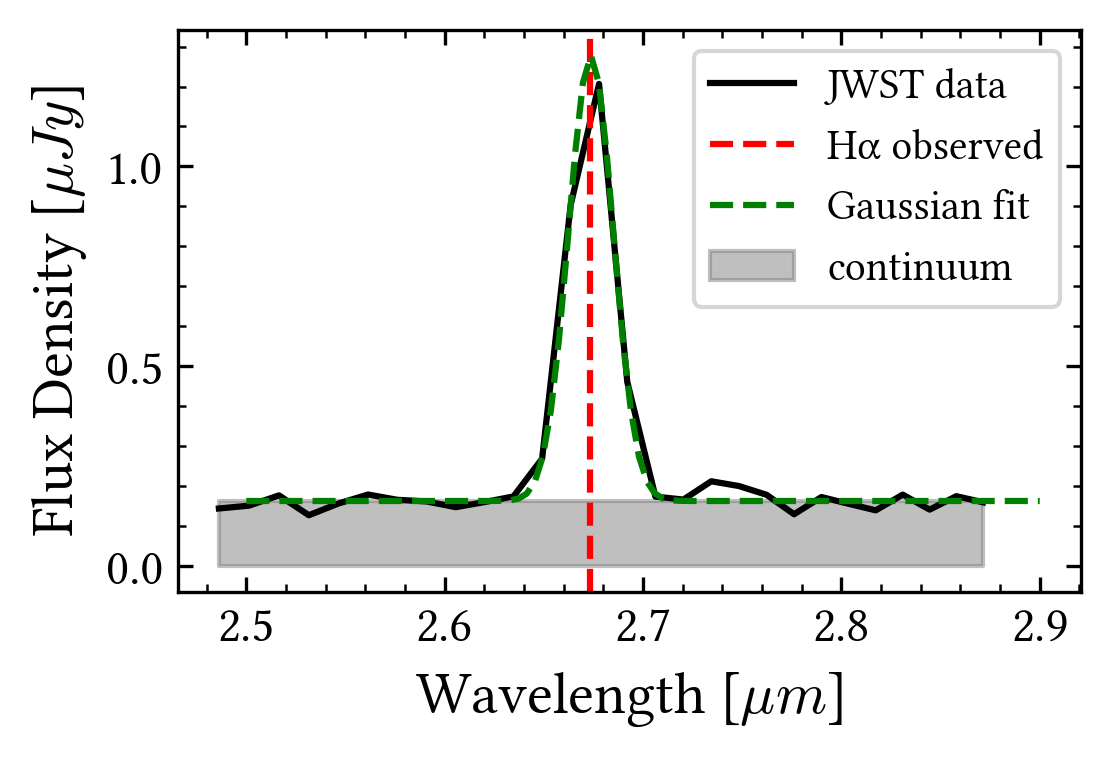

Area of the Gaussian, i.e. Ha flux: 0.0315 micro Jansky * micro meters
A, mu, sigma, C [1.11434218 2.67373105 0.01129372 0.16315985]


In [37]:
import scipy.stats as scs
from scipy.optimize import curve_fit

# Example values
ID = 22812
z_value = id_to_z.get(ID, None)
Ha = 6563  
wave, flux, error = open_fits(ID)

# Observed 
Ha_obs = Ha*1e-4*(1+z_value)  # in µm

# sliced window
delta = 0.2  # µm
mask = (wave >= Ha_obs - delta) & (wave <= Ha_obs + delta)

wave_slice = wave[mask]
flux_slice = flux[mask]

# Plot full spectrum
fig = figure(figsize=small_fsize)
frame = fig.add_subplot()

frame.plot(wave_slice, flux_slice, color='black',label='JWST data')

frame.set_xlabel(r'Wavelength [$\mu m$]')
frame.set_ylabel(r'Flux Density [$\mu Jy$]')

#frame.axvline(Ha*1e-4, c='red', linestyle=':', label='Hα rest')
frame.axvline(Ha_obs, c='red', linestyle='--', label='Hα observed')
if show_title: frame.set_title(r"Slice around H$_{\alpha , obs}$ with Gaussian fit for ID=22812")

# C accounts for the continuum
def gaussian(x, A, mu, sigma, C):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2)) + C

params, cov = curve_fit(gaussian, wave_slice, flux_slice, p0=[1.2,Ha_obs,0.05,flux_slice.min()])

#fitting parameters
A_fit, mu_fit, sigma_fit, continuum = params

#plot fit and subtract the continuum
frame.plot(np.linspace(2.5,2.9,100), gaussian(np.linspace(2.5,2.9,100), A_fit, mu_fit, sigma_fit, continuum), 'g--', label='Gaussian fit')
frame.fill_between(wave_slice, 0, continuum, color='grey', alpha=0.5, label='continuum')
frame.legend(fontsize=10)
plt.tight_layout()

area = A_fit * abs(sigma_fit) * np.sqrt(2*np.pi) #micro Jy * micro m
plt.savefig(fname="Gaussian-slice.pdf",format='pdf')
show()

print(fr"Area of the Gaussian, i.e. Ha flux: {area:.4f} micro Jansky * micro meters")
print("A, mu, sigma, C", params)

In [38]:
#example for the above ID
from astropy.cosmology import Planck18 as cosmo

#convert lineflux to cgs
F_Ha_cgs = (area * 1e-33 * 3e10) / ((Ha_obs *1e-4)**2) #erg s-1 cm-2

#luminosity distance
z = z_value
dL = cosmo.luminosity_distance(z)
dL_cm = dL.to('cm')

#H_alpha luminosity
L_H = 4*np.pi*dL_cm.value**2 * F_Ha_cgs

print(f"H_alpha luminosity for ID={ID}: {L_H:.2e} erg s^-1")

H_alpha luminosity for ID=22812: 1.14e+42 erg s^-1


## (iv) H_alpha luminosity for all objects

In [ ]:
L_Ha_dict = {}
F_Ha_dict = {}
L_Ha_err_dict = {}
F_Ha_err_dict = {}

#go over all IDs
for ID, z_value in id_to_z.items():
    wave, flux, error = open_fits(ID)
    
    # observed
    Ha_obs = Ha*1e-4*(1+z_value)  # µm
    
    # choose some wavelength range around peak (±0.2 micron)
    delta = 0.2
    mask = (wave >= Ha_obs - delta) & (wave <= Ha_obs + delta)
    wave_slice = wave[mask]
    flux_slice = flux[mask]
    error_slice = error[mask]
    
    # gaussian
    def gaussian(x, A, mu, sigma, C):
        return A * np.exp(-(x - mu)**2 / (2*sigma**2)) + C
    
    params, cov = curve_fit(gaussian, wave_slice, flux_slice, p0=[flux_slice.max(), Ha_obs, 0.05, flux_slice.min()], sigma=error_slice, absolute_sigma=True)
    A_fit, mu_fit, sigma_fit, continuum = params
    perr = np.sqrt(np.diag(cov))
    A_err, mu_err, sigma_err, continuum_err = perr
    
    # area
    area = A_fit * abs(sigma_fit) * np.sqrt(2*np.pi)
    area_err = np.sqrt((abs(sigma_fit)*np.sqrt(2*np.pi)*A_err)**2 + (A_fit*np.sqrt(2*np.pi)*sigma_err)**2)
    
    # convert to cgs
    lambda_cm = Ha_obs * 1e-4  # µm → cm
    F_Ha_cgs = (area * 1e-29 * 1e-4) * (3e10 / lambda_cm**2)  # erg/s/cm²
    F_Ha_err = (area_err * 1e-29 * 1e-4) * (3e10 / lambda_cm**2)
    
    # luminosity 
    dL = cosmo.luminosity_distance(z_value)
    dL_cm = dL.to('cm')
    L_Ha = 4 * np.pi * dL_cm.value**2 * F_Ha_cgs
    L_Ha_err = 4 * np.pi * dL_cm.value**2 * F_Ha_err
    
    # save all values
    L_Ha_dict[ID] = L_Ha
    F_Ha_dict[ID] = F_Ha_cgs
    L_Ha_err_dict[ID] = L_Ha_err
    F_Ha_err_dict[ID] = F_Ha_err

# For display
for ID, L in L_Ha_dict.items():
    print(f"ID={ID}: L_Hα = {L:.2e} erg/s ± {L_Ha_err_dict[ID]:.2e}")

# # For Latex Report
# print("ID & L_Hα \\\\")
# for ID, L in L_Ha_dict.items():
#     print(f"{ID} & {L:.2e} \\pm {L_Ha_err_dict[ID]:.2e}\\\\")

In [ ]:
# star formation rates

# log M_star (solar masses per year) = log L_H_alpha - log (cH_alpha) [constant]

SFR_dict = {}
SFR_err_dict = {}

#formula from paper
def SFR_calculator(L, L_err):
    rate = L * 10**(-41.27)
    rate_err_lum = L_err * 10**(-41.27)
    rate_err_rel = 0.3 * rate
    rate_err = np.sqrt(rate_err_lum**2 + rate_err_rel**2)
    return rate, rate_err

for ID, L in L_Ha_dict.items():
    L_err = L_Ha_err_dict[ID]
    SFR, SFR_err = SFR_calculator(L, L_err)
    SFR_dict[ID] = SFR
    SFR_err_dict[ID] = SFR_err

    
# print(f"SFR for ID={22812}: {SFR_dict[22812]:.4} ± {SFR_err_dict[22812]:.4} solar masses per year")

print('ID & SFR \\\\')
for ID, SFR in SFR_dict.items():
    print(f'{ID} & {SFR:.2} \\pm {SFR_err_dict[ID]:.2} \\\\')

ID & SFR \\
772 & 1.4e+01 \pm 4.1 \\
804 & 1.3e+01 \pm 3.9 \\
1109 & 5.6 \pm 1.7 \\
1167 & 3.3 \pm 1.0 \\
1961 & 1.7 \pm 0.55 \\
8803 & 1.9 \pm 0.61 \\
16125 & 2.7 \pm 0.83 \\
22266 & 1.6 \pm 0.48 \\
22812 & 6.1 \pm 1.8 \\
26566 & 1.5e+01 \pm 4.6 \\
26788 & 2.4 \pm 0.86 \\
27145 & 1.7e+01 \pm 5.1 \\
30578 & 0.5 \pm 0.22 \\
31479 & 2.4 \pm 0.73 \\
31873 & 1.3 \pm 0.4 \\
49372 & 1.8 \pm 0.55 \\
70173 & 1.1e+01 \pm 3.2 \\
71890 & 1.6e+01 \pm 4.9 \\
79534 & 3.5 \pm 1.1 \\
113 & 4.3 \pm 1.4 \\
761 & 6.5 \pm 2.0 \\
903 & 5.3 \pm 1.7 \\
3012 & 6.9 \pm 2.2 \\
6189 & 1.4 \pm 0.55 \\
14285 & 2.4 \pm 0.84 \\
24707 & 8.2 \pm 2.5 \\
44699 & 2.3 \pm 0.98 \\
47918 & 3.4 \pm 1.2 \\
53927 & 9.6 \pm 3.0 \\
54834 & 3.1 \pm 1.1 \\
62309 & 5.7 \pm 1.7 \\
79349 & 7.0 \pm 2.1 \\
80185 & 7.4 \pm 2.3 \\
81497 & 2.5 \pm 0.84 \\
83030 & 4.5 \pm 1.7e+05 \\


## (v) Stellar Mass Estimation

In [41]:
with fits.open('jades_goods-n_photometry.fits') as hdul:
    data = hdul[1].data
    #print(data.columns)
    #print(len(data.NIRSpec_ID))

lambda_rest = 1500
lambda_obs_dict = {}

# over IDs
for ID, z_value in id_to_z.items():
    lambda_obs = lambda_rest * (1 + z_value)  # observed wavelength in Å
    lambda_obs_dict[ID] = lambda_obs * 1e-4

# uncomment to print the corresponding wavelength
#for ID, lam in lambda_obs_dict.items():
#    print(f"ID={ID}: λ_obs = {lam:.2f} micron")

In [42]:
#manually stored which filters are relevant for each ID

filters_dict = {}

filters_dict[772] = ['F775W','F814W']
filters_dict[804] = ['F775W','F814W','F606W']
filters_dict[1109] = ['F775W','F814W']
filters_dict[1167] = ['F775W','F814W','F606W']
filters_dict[1961] = ['F775W','F814W','F606W']
filters_dict[8803] = ['F606W']
filters_dict[16125] = ['F606W']
filters_dict[22266] = ['F606W']
filters_dict[22812] = ['F606W']
filters_dict[26566] = ['F606W']
filters_dict[26788] = ['F775W','F814W']
filters_dict[27145] = ['F606W']
filters_dict[30578] = ['F606W']
filters_dict[31479] = ['F606W']
filters_dict[31873] = ['F606W']
filters_dict[49372] = ['F606W']
filters_dict[70173] = ['F606W']
filters_dict[71890] = ['F606W']
filters_dict[113] = ['F850LP','F105W','F090W','F115W']
filters_dict[761] = ['F850LP','F105W','F090W']
filters_dict[903] = ['F850LP','F105W','F090W','F115W']
filters_dict[3012] = ['F814W','F850LP','F105W','F090W']
filters_dict[6189] = ['F814W','F850LP','F105W','F090W']
filters_dict[14285] = ['F850LP','F105W','F090W']
filters_dict[24707] = ['F850LP','F105W','F115W']
filters_dict[44699] = ['F814W','F850LP','F105W','F090W']
filters_dict[47918] = ['F850LP','F105W','F090W','F115W']
filters_dict[53927] = ['F850LP','F105W','F115W']
filters_dict[54834] = ['F850LP','F105W','F090W','F115W']
filters_dict[62309] = ['F814W','F850LP','F105W','F090W']
filters_dict[79349] = ['F814W','F850LP','F105W','F090W']
filters_dict[80185] = ['F850LP','F105W','F090W']
filters_dict[81497] = ['F814W','F850LP','F105W','F090W']
filters_dict[83030] = ['F814W','F850LP','F105W','F090W']

In [43]:


flux_spectra = {}
flux_spectra_err = {}
i = 0
#loop over all objects and their filters, if more than one is relevant the median is taken
for ID, filters in filters_dict.items():
    # row match
    mask = data['NIRSpec_ID'] == ID
    matched_rows = data[mask]
    
    flux_list = []
    flux_err_list = []
    
    for f in filters:
        col_name = f"{f}_KRON"
        err_name = f"{f}_KRON_e"
        flux_values = matched_rows[col_name]
        flux_errors = matched_rows[err_name]
        flux_list.extend(flux_values)
        flux_err_list.extend(flux_errors)
    
    flux_median = np.median(flux_list)
    flux_err = np.sqrt(np.sum(np.array(flux_err_list)**2)) / len(flux_err_list)
    
    flux_spectra[ID] = flux_median * 1e-9
    flux_spectra_err[ID] = flux_err * 1e-9


# uncomment the next lines if you want to check the resulting values of the flux

#for ID in flux_spectra:
#    print(f"ID {ID}: f = {flux_spectra[ID]:.2e} Jy")
    
    



In [44]:
# luminosity distances calculation for all IDs

dL_dict_pc = {}
for ID, z_value in id_to_z.items():
    dL = cosmo.luminosity_distance(z_value)
    dL_pc = dL.to('pc')
    dL_dict_pc[ID] = dL_pc

In [45]:
#calculate the flux at rest and use that in paper's formula to find the mass estimation

flux_spectra_rest = {}

for ID, f in flux_spectra.items(): 
    z = id_to_z.get(ID, None) # convert to rest frame 
    f_rest = f / (1 + z) 
    flux_spectra_rest[ID] = f_rest
    
M = {}; M_err = {} 

for ID, f_rest in flux_spectra_rest.items(): # calculate apparent magnitude 
    m = -2.5*np.log10(f_rest) + 8.9 # absolute magnitude 
    absolute_M = m - 5*(np.log10(dL_dict_pc.get(ID, None).value)-1) # error 
    f_err = flux_spectra_err.get(ID, None) 
    sigma_m = 1.0857 * (f_err / f_rest) # error in magnitudes 
    M[ID] = absolute_M 
    M_err[ID] = sigma_m



In [46]:
#uncomment to check all absolute magnitudes

#for ID, absol in M.items():
#   print(f"Absolute Magnitude {ID}: {M[ID]:.3f}")

In [47]:
masses = {}
masses_err = {}

#mass calculation from absolute magnitude
for ID, abs_m in M.items():
    z = id_to_z.get(ID, None)
    logM = -0.5*(abs_m + 19.5) + (-2.4*np.log10(1+z)+11)
    
    # propagate absolute magnitude error
    sigma_log_from_mag = 0.5 * M_err[ID] 
    sigma_log_total = np.sqrt(sigma_log_from_mag**2 + 0.4**2)
    
    mass_lin = 10**logM
    mass_lin_err = mass_lin * sigma_log_total  # convert log error to linear error
    
    masses[ID] = mass_lin
    masses_err[ID] = np.log10(mass_lin_err) / 10**(1.5)

In [48]:
for ID, mass in masses.items():
    print(f"Mass {ID}: {masses[ID]:.2e} ± {masses_err[ID]:.2e} Solar Mass")

Mass 772: 4.40e+09 ± 2.93e-01 Solar Mass
Mass 804: 1.22e+10 ± 3.07e-01 Solar Mass
Mass 1109: 5.73e+09 ± 2.96e-01 Solar Mass
Mass 1167: 2.47e+08 ± 2.61e-01 Solar Mass
Mass 1961: 8.17e+08 ± 2.72e-01 Solar Mass
Mass 8803: 4.29e+08 ± 2.67e-01 Solar Mass
Mass 16125: 1.89e+09 ± 2.85e-01 Solar Mass
Mass 22266: 1.83e+09 ± 2.84e-01 Solar Mass
Mass 22812: 7.72e+09 ± 3.00e-01 Solar Mass
Mass 26566: 1.16e+10 ± 3.06e-01 Solar Mass
Mass 26788: 7.19e+08 ± 2.71e-01 Solar Mass
Mass 27145: 7.57e+09 ± 3.01e-01 Solar Mass
Mass 30578: 1.02e+09 ± 2.82e-01 Solar Mass
Mass 31479: 3.70e+09 ± 2.92e-01 Solar Mass
Mass 31873: 3.27e+08 ± 2.65e-01 Solar Mass
Mass 49372: 4.41e+08 ± 2.63e-01 Solar Mass
Mass 70173: 2.74e+10 ± 3.18e-01 Solar Mass
Mass 71890: 5.90e+09 ± 2.99e-01 Solar Mass
Mass 113: 1.09e+09 ± 2.78e-01 Solar Mass
Mass 761: 1.09e+09 ± 2.78e-01 Solar Mass
Mass 903: 1.73e+09 ± 2.82e-01 Solar Mass
Mass 3012: 7.40e+08 ± 2.75e-01 Solar Mass
Mass 6189: 6.33e+08 ± 2.75e-01 Solar Mass
Mass 14285: 3.82e+08 ± 2.71

## Mass Histograms

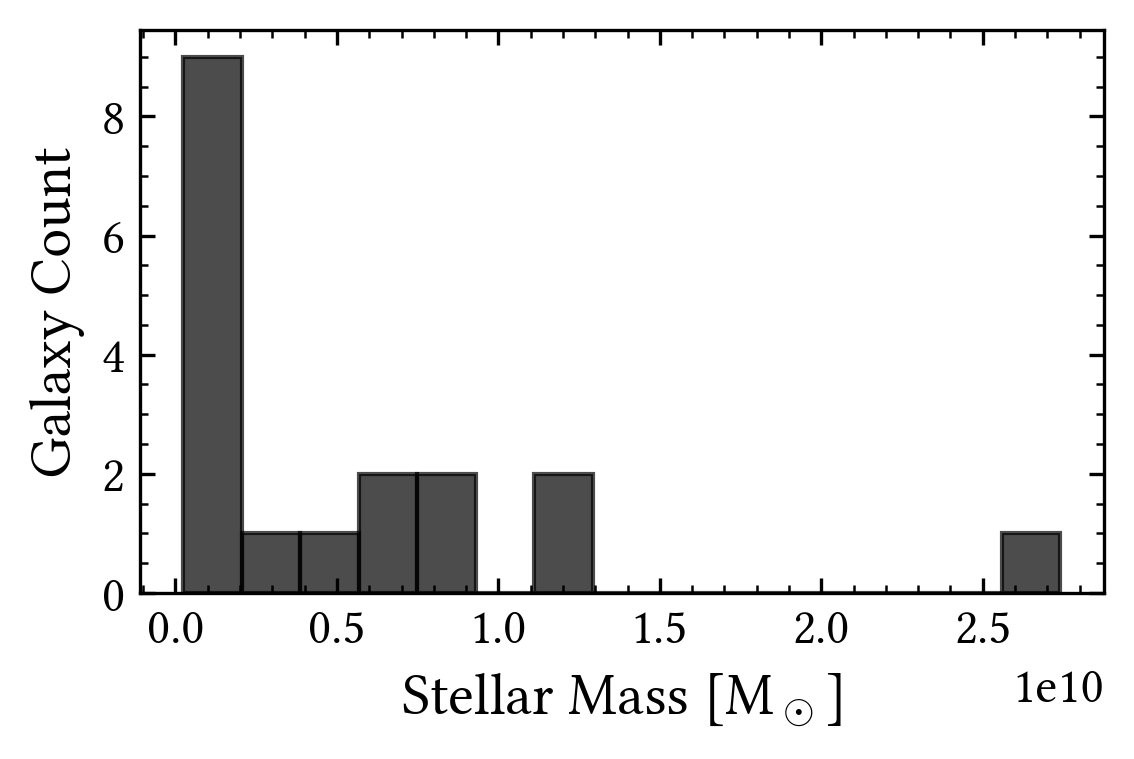

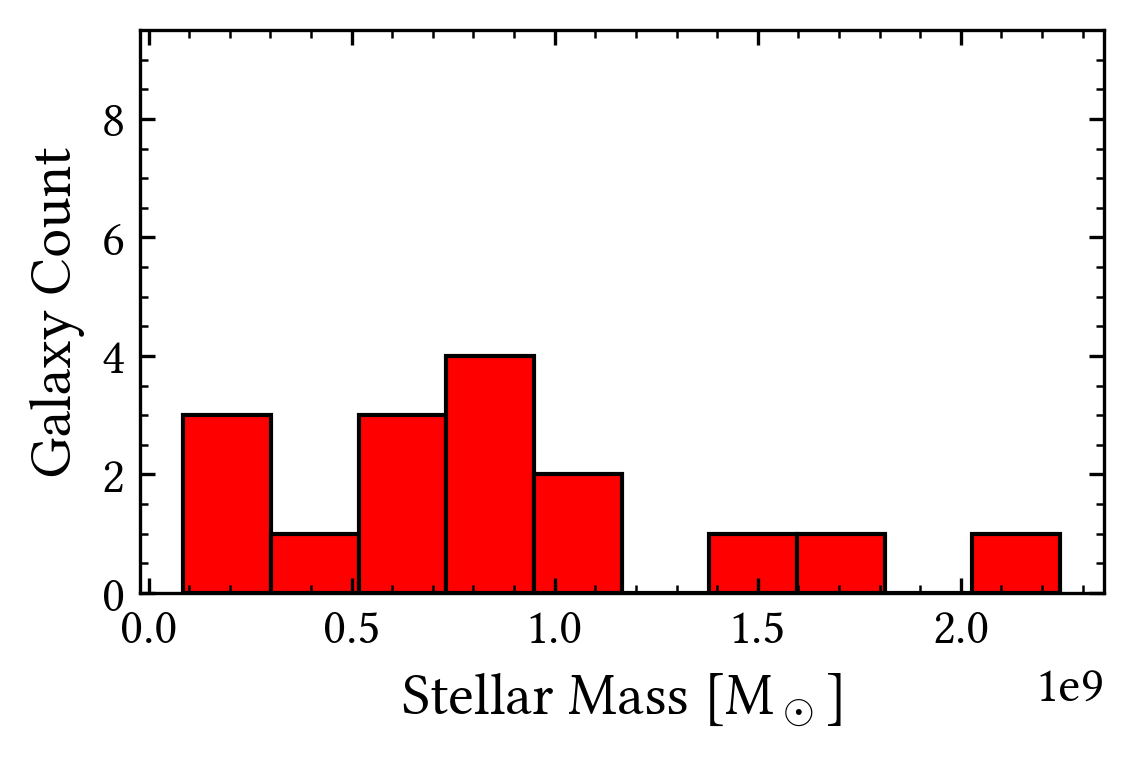

In [49]:
masses_34 = np.array([masses[ID] for ID in IDs_34 if ID in masses])  #takes the mass of object ID only if it is in z 3-4 range
masses_56 = np.array([masses[ID] for ID in IDs_56 if ID in masses])  #takes the mass of object ID only if it is in z 5-6 range

# Plot for z:3-4
plt.figure(figsize=small_fsize)
plt.hist(masses_34, bins=15, edgecolor='k', alpha=.7, label=r"$z=3\dots 4$")  #histogram for z:3-4
plt.xlabel(r"Stellar Mass [M$_\odot$]")
plt.ylabel("Galaxy Count")
#plt.xscale('log')
if show_title: plt.title(r"Stellar Mass Distribution for Galaxies $z=3\dots 4$")
plt.tight_layout()
plt.savefig(fname="Mass-Histogram-34.pdf", format='pdf')
plt.show()

# Plot for z:5-6
plt.figure(figsize=small_fsize)
plt.hist(masses_56, bins=10, edgecolor='k', alpha=1, color='red', label=r"$z=5\dots 6$")  #histogram for z:5-6
plt.ylim(0,9.5)
plt.xlabel(r"Stellar Mass [M$_\odot$]")
plt.ylabel("Galaxy Count")
#plt.xscale('log')
if show_title: plt.title(r"Stellar Mass Distribution for Galaxies $z=5\dots 6$")
plt.tight_layout()
plt.savefig(fname="Mass-Histogram-56.pdf", format='pdf')
plt.show()

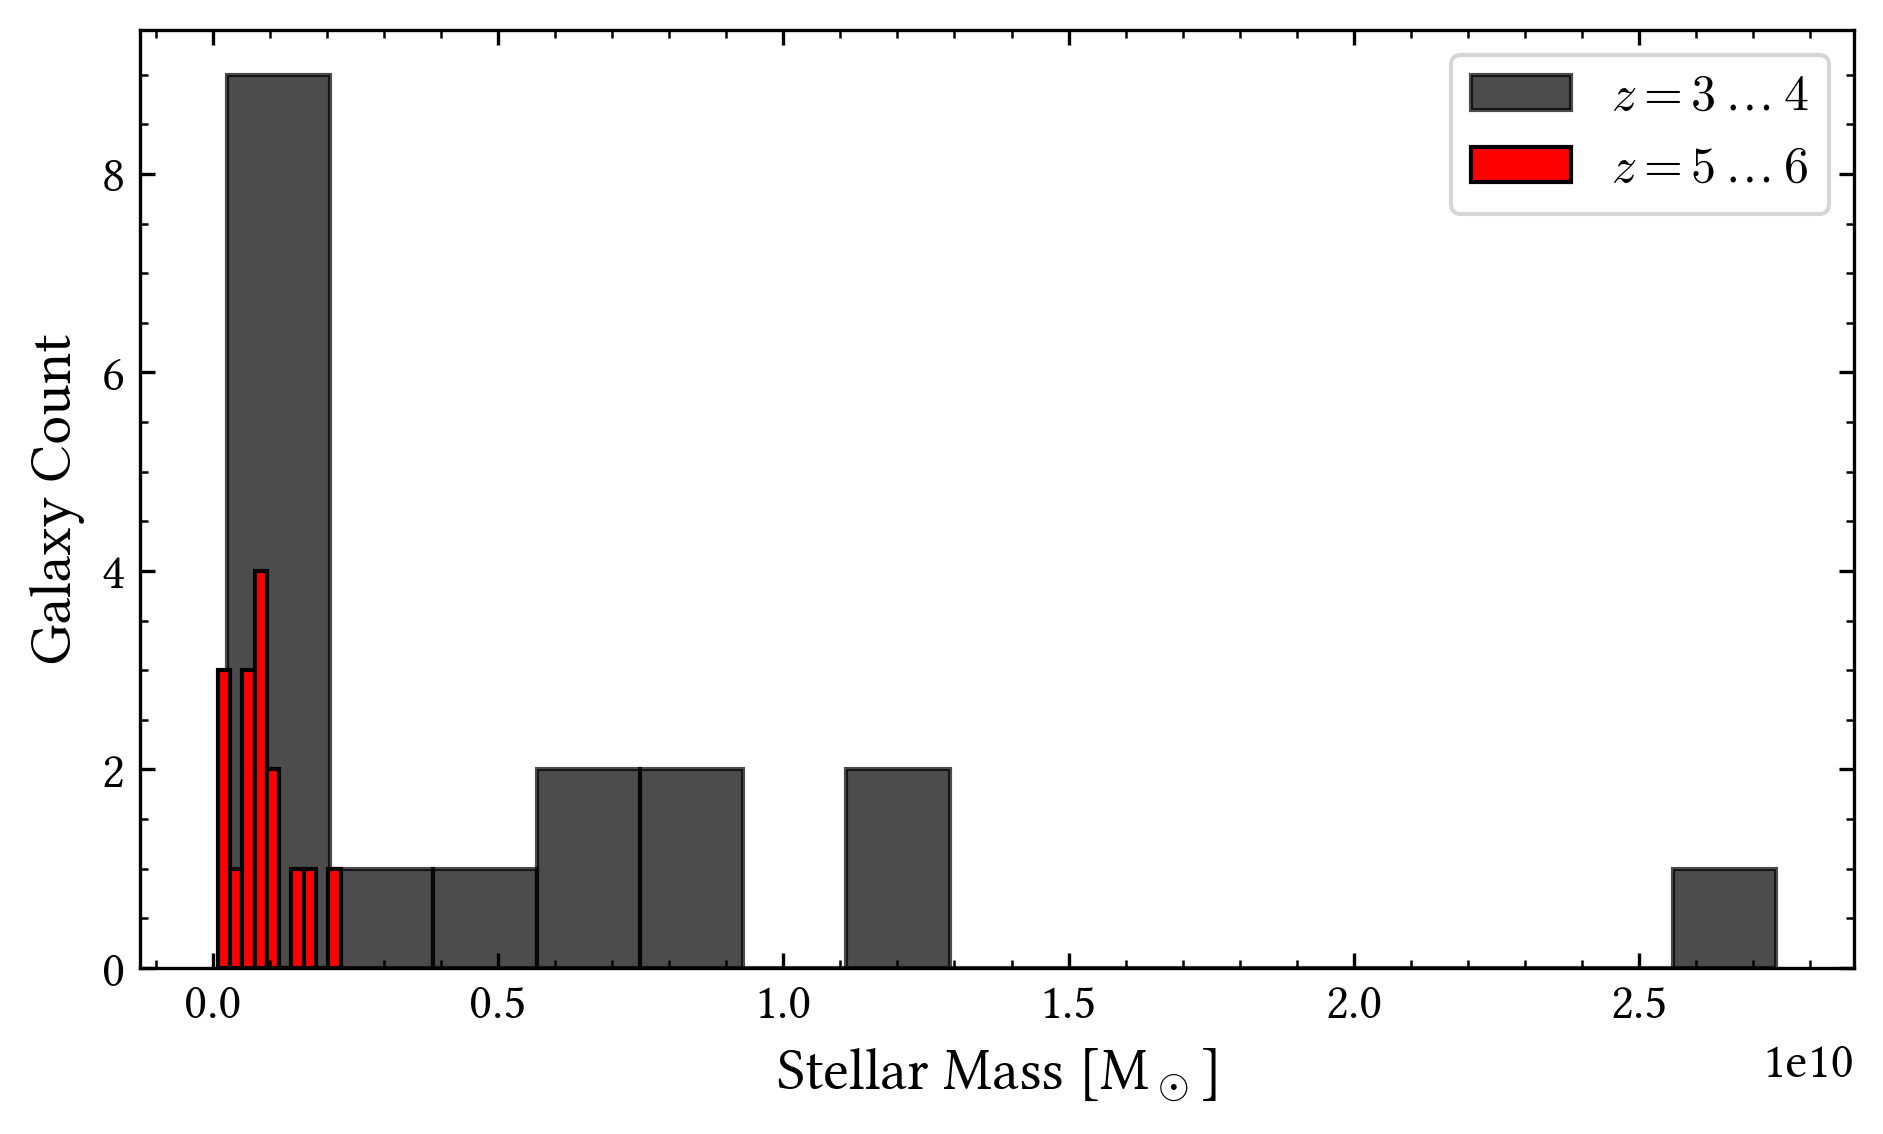

In [50]:
masses_34 = np.array([masses[ID] for ID in IDs_34 if ID in masses]) #takes the mass of object ID only if it is in z 3-4 range
masses_56 = np.array([masses[ID] for ID in IDs_56 if ID in masses]) #takes the mass of object ID only if it is in z 5-6 range

plt.figure(figsize=wide_fsize)

plt.hist(masses_34, bins=15, edgecolor='k', alpha=.7, label=r"$z=3\dots 4$") #histogram for z:3-4
plt.hist(masses_56, bins=10, edgecolor='k', alpha=1, color='red', label=r"$z=5\dots 6$") #histogram for z:5-6


plt.xlabel(r"Stellar Mass [M$_\odot$]")
plt.ylabel("Galaxy Count")
if show_title: plt.title(r"Combined Stellar Mass Distribution")
plt.legend(fontsize=12)
#plt.yscale('log')
plt.tight_layout()
plt.savefig(fname="Mass-Histogram-fused.pdf", format='pdf')
plt.show()


## Stellar Mass vs SFR Plots


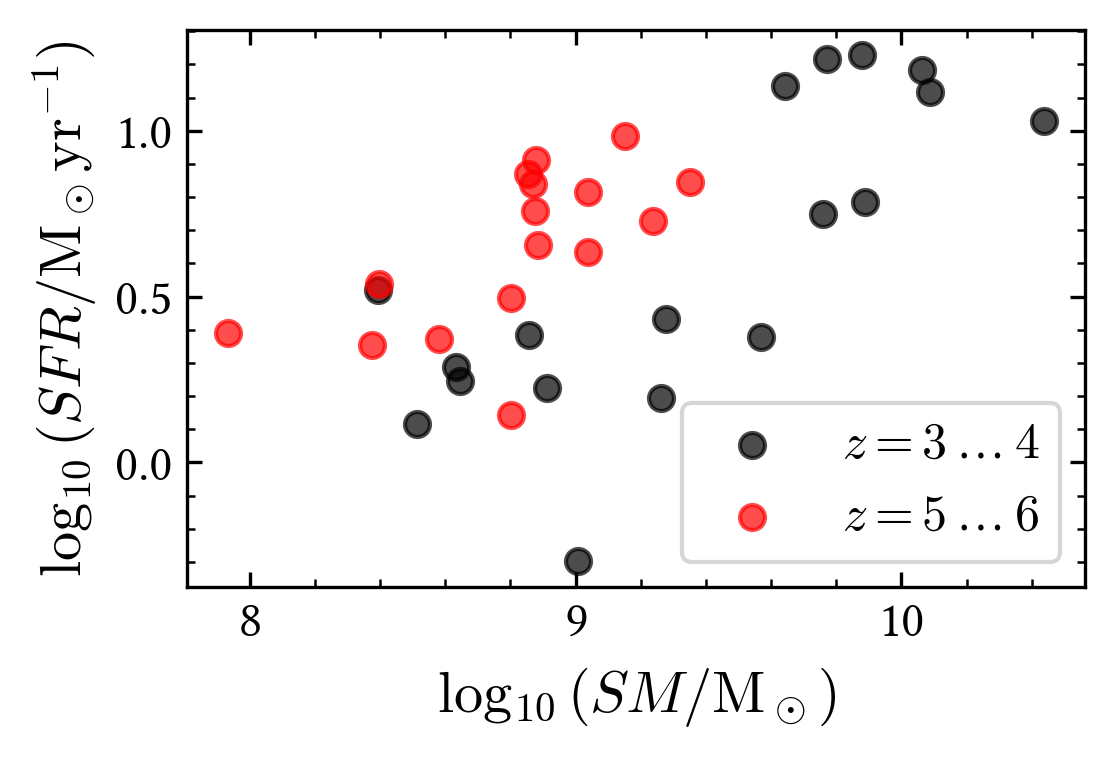

In [51]:
SFR_34 = np.array([SFR_dict[ID] for ID in IDs_34 if ID in masses])
SFR_56 = np.array([SFR_dict[ID] for ID in IDs_56 if ID in masses])

masses_34 = np.array([masses[ID] for ID in IDs_34 if ID in masses]) #takes the mass of object ID only if it is in z 3-4 range
masses_56 = np.array([masses[ID] for ID in IDs_56 if ID in masses]) #takes the mass of object ID only if it is in z 5-6 range

#order the arrays for clean plotting
sort_idx_34 = np.argsort(SFR_34)
SFR_34_sorted = SFR_34[sort_idx_34]
masses_34_sorted = np.log10(masses_34[sort_idx_34])

sort_idx_56 = np.argsort(SFR_56)
SFR_56_sorted = SFR_56[sort_idx_56]
masses_56_sorted = np.log10(masses_56[sort_idx_56])

#plotting
plt.figure(figsize=small_fsize)

plt.scatter(masses_34_sorted, np.log10(SFR_34_sorted), alpha=.7, label=r"$z = 3\dots 4$") #plot for z:3-4
plt.scatter(masses_56_sorted, np.log10(SFR_56_sorted), alpha=.7, color='red', label=r"$z = 5\dots 6$") #plot for z:5-6

#plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r"$\log_{10}(SFR/\text{M}_\odot \text{yr}^{-1})$")
plt.xlabel(r"$\log_{10}(SM/\text{M}_\odot)$")
if show_title: plt.title("Stellar Mass vs Star Formation Rate")
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig(fname="mass_v_sfr.pdf", format='pdf')
show()

## Include Popesso et al. 2022

In [52]:
#find cosmic time of my galaxy groups

z34 = np.median(z_34)
z56 = np.median(z_56)

t_cosmic_34 = cosmo.age(z34).value  # in Gyr
t_cosmic_56 = cosmo.age(z56).value

#calculate 

In [53]:

def sf_main_sequence(M, t, a, da):
    a0, a1, a2, a3, a4 = a
    da0, da1, da2, da3, da4 = da
    
    M = np.array(M)
    
    x = M / 10**(a2 + a3*t)
    logSFR = a0 + a1*t - np.log10(1 + x**(-a4))
    
    common = x**(-a4) / (1 + x**(-a4))
    lnx = np.log(x)

    dloga0 = 1
    dloga1 = t
    dloga2 = a4 * common
    dloga3 = t * dloga2
    dloga4 = common * lnx / np.log(10)
    
    dlogSFR = np.sqrt(
        (dloga0*da0)**2 + (dloga1*da1)**2 + (dloga2*da2)**2 +
        (dloga3*da3)**2 + (dloga4*da4)**2
    )
    
    return logSFR, dlogSFR


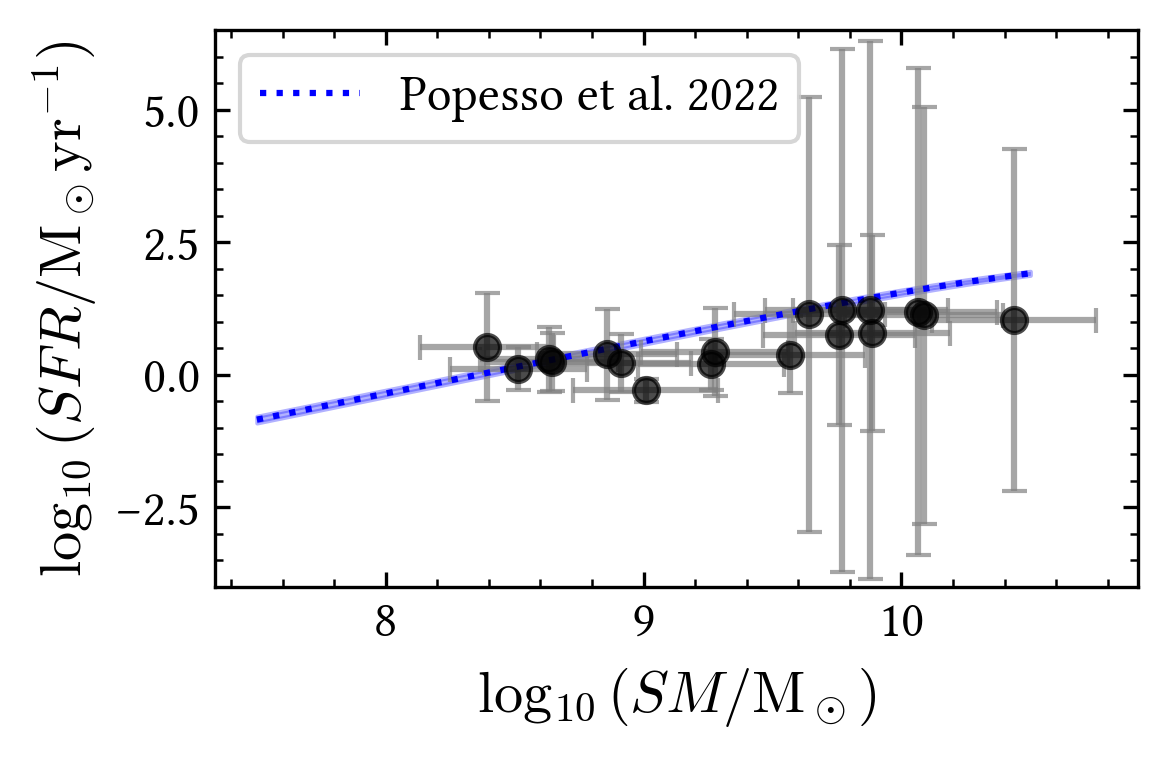

In [60]:
# calculate SFR for a sensible mass range

mass = np.linspace(10**7.5, 10**10.5,1000)
masses_56 = np.array([masses[ID] for ID in IDs_56 if ID in masses and ID != 83030])

# Popesso+2022 parameters and uncertainties
a = [2.693, -0.186, 10.85, -0.0729, 0.99]
da = [0.012, 0.009, 0.05, 0.0024, 0.01]

logSFR_34, dlogSFR_34 = sf_main_sequence(mass, t_cosmic_34, a, da)
logSFR_56, dlogSFR_56 = sf_main_sequence(mass, t_cosmic_56, a, da)

x_err = [masses_err[ID] for ID in IDs_34 if ID in masses] 
y_err = [SFR_err_dict[ID] for ID in IDs_34 if ID in masses]

#plotting
plt.figure(figsize=small_fsize)

SFR_34 = np.array([SFR_dict[ID] for ID in IDs_34 if ID in masses])
SFR_56 = np.array([SFR_dict[ID] for ID in IDs_56 if ID in masses and  ID != 83030])

# plt.scatter(np.log10(masses_34), np.log10(SFR_34), alpha=.7) #plot for z:3-4

plt.errorbar(
    np.log10(masses_34), 
    np.log10(SFR_34), 
    xerr=x_err, 
    yerr=y_err, 
    fmt='o', 
    alpha=0.7, 
    ecolor='gray', 
    capsize=3, 
    #label='Data z:3-4'
)

plt.plot(np.log10(mass), logSFR_34, c='blue',linestyle=':',label='Popesso et al. 2022')

plt.fill_between(np.log10(mass), logSFR_34-dlogSFR_34, logSFR_34+dlogSFR_34, color='blue', alpha=0.3)


#plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r"$\log_{10}(SFR/\text{M}_\odot \text{yr}^{-1})$")
plt.xlabel(r"$\log_{10}(SM/\text{M}_\odot)$")
if show_title: plt.title(r"Stellar Mass vs Star Formation Rate for $z=3\dots 4$")
plt.legend()
plt.ylim(-4,6.5)

plt.tight_layout()
plt.savefig(fname="mass_v_sfr_34.pdf", format='pdf')
show()

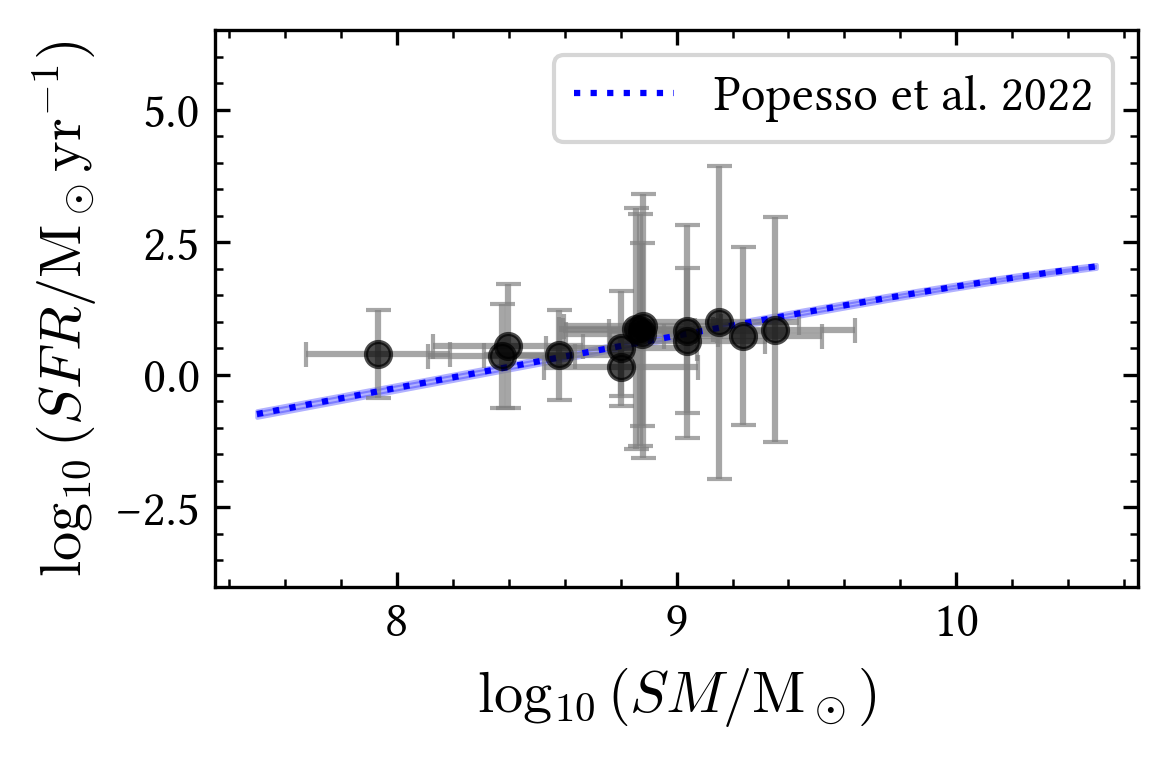

In [61]:
plt.figure(figsize=small_fsize)

x_err = [masses_err[ID] for ID in IDs_56 if ID in masses and ID != 83030] 
y_err = [SFR_err_dict[ID] for ID in IDs_56 if ID in masses and ID != 83030]

plt.errorbar(
    np.log10(masses_56), 
    np.log10(SFR_56), 
    xerr=x_err, 
    yerr=y_err,
    fmt='o', 
    alpha=0.7, 
    ecolor='gray', 
    capsize=3, 
    #label='Data z:3-4'
)


#plt.scatter(np.log10(masses_56), np.log10(SFR_56), alpha=1, color='red') #plot for z:5-6
plt.plot(np.log10(mass), logSFR_56, c='blue',linestyle=':',label='Popesso et al. 2022')

plt.fill_between(np.log10(mass), logSFR_56-dlogSFR_56, logSFR_56+dlogSFR_56, color='blue', alpha=0.3)

plt.ylabel(r"$\log_{10}(SFR/\text{M}_\odot \text{yr}^{-1})$")
plt.xlabel(r"$\log_{10}(SM/\text{M}_\odot)$")
if show_title: plt.title(r"Stellar Mass vs Star Formation Rate for $z=5\dots 6$")
plt.legend()
plt.ylim(-4,6.5)
plt.tight_layout()
plt.savefig(fname="mass_v_sfr_56.pdf", format='pdf')
show()

